In [1]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [188]:
#helpers
def GetSeason(row):
    if (row["Month"] >= 9):
        return row["Year"]
    else:
        return row["Year"] - 1
def GetPlayerLogs(gamelogs,player):
    playerlogs = gamelogs[gamelogs["Player"] == player]
    playerlogs.set_index("Date",inplace=True)
    playerlogs.sort_index(inplace=True)
    playerlogs.reset_index(inplace=True)
    playerlogs["Year"] = pd.DatetimeIndex(playerlogs['Date']).year
    playerlogs["Month"] = pd.DatetimeIndex(playerlogs['Date']).month
    playerlogs["Season"] = playerlogs.apply(lambda row: GetSeason(row),axis=1)
    playerlogs["Rest"] = (playerlogs.Date - playerlogs.Date.shift(1)).dt.days

    playerlogs["FPTS"] = playerlogs["PTS"] * 1 + playerlogs["TRB"] * 1.2 + playerlogs["AST"] * 1.5 \
                            + playerlogs["STL"] * 3 + playerlogs["BLK"] * 3 - playerlogs["TOV"] 

    playerlogs.set_index("Date",inplace=True)
    playerlogs.sort_index(inplace=True)
    return playerlogs 

def GetPlayerSeasonSummary(rplayerlogs,rollingwindow = 5):
    seasons = playerlogs["Season"].unique()
    summary = []
    for season in seasons:
        seasonstats = playerlogs[playerlogs["Season"] == season]
        seasonstats.reset_index(inplace=True)
        seasonstats["game"] = seasonstats.index + 1
        seasonstats["ma_PTS"] = seasonstats["PTS"].rolling(rollingwindow).mean()
        seasonstats["ma_AST"] = seasonstats["AST"].rolling(rollingwindow).mean()
        seasonstats["ma_TRB"] = seasonstats["TRB"].rolling(rollingwindow).mean()
        seasonstats["ma_STL"] = seasonstats["STL"].rolling(rollingwindow).mean()
        seasonstats["ma_BLK"] = seasonstats["BLK"].rolling(rollingwindow).mean()
        seasonstats["ma_TOV"] = seasonstats["TOV"].rolling(rollingwindow).mean()
        seasonstats["ma_FPTS"] = seasonstats["FPTS"].rolling(rollingwindow).mean()
        seasonstats["prev_PTS"] = seasonstats["PTS"].shift(1)
        seasonstats["prev_AST"] = seasonstats["AST"].shift(1)
        seasonstats["prev_TRB"] = seasonstats["TRB"].shift(1)
        seasonstats["prev_FPTS"] = seasonstats["FPTS"].shift(1)
        seasonstats["prev_STL"] = seasonstats["STL"].shift(1)
        seasonstats["prev_BLK"] = seasonstats["BLK"].shift(1)
        
        summary.append(seasonstats)

    summarydf = pd.concat(summary)
    summarydf.set_index("Date",inplace=True)
    summarydf.sort_index(inplace=True)
    
    return summarydf

In [4]:
# Data Preparation

#Team Logs
url = "C:/My/pyprojects/NBA/TeamLogs/AdvancedData.csv"
teamlogs = pd.read_csv(url)
teamlogs["Date"] = pd.to_datetime(teamlogs["Date"])

#Player Logs
url = "C:/My/pyprojects/NBA/GameLogs/AllPlayersLogs.csv"
playerdata = pd.read_csv(url)
playerdata["Date"] = pd.to_datetime(playerdata["Date"])

#Combine Team and Opponent Data
teamlogssummaryjoined = pd.merge(teamlogs, teamlogs,  how='left', left_on=['Date','Opp'], \
                                 right_on = ['Date','Tm'],suffixes=["_T","_O"])

#Combine Team and Player Data
gamelogscomplete = pd.merge(playerdata, teamlogssummaryjoined,  how='left', left_on=['Date','Tm'], \
                            right_on = ['Date','Tm_T'])

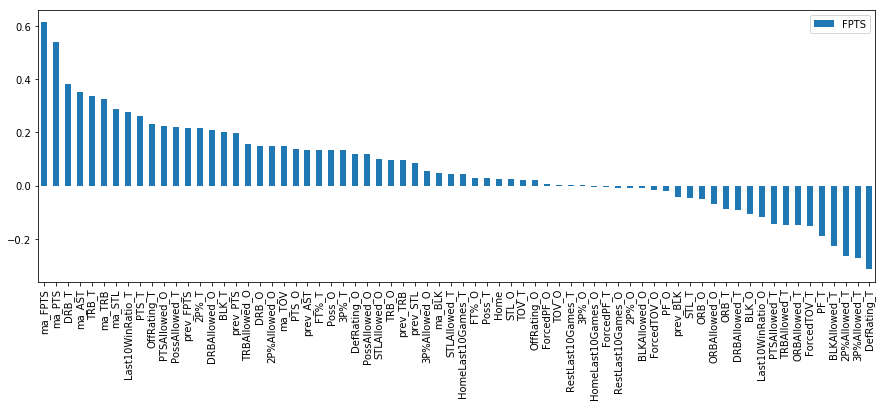

In [183]:
#Correlation

predictors = [
    "Home",
    "2P%Allowed_T",
    "3P%Allowed_T",
    "PTSAllowed_T",
    "ORBAllowed_T",
    "DRBAllowed_T",
    "TRBAllowed_T",
    "STLAllowed_T",
    "BLKAllowed_T",
    "ForcedTOV_T",
    "ForcedPF_T",
    "PossAllowed_T",
    "Last10WinRatio_T",
    "RestLast10Games_T",
    "HomeLast10Games_T",
    "2P%_T",
    "3P%_T",
    "FT%_T",
    "PTS_T",
    "ORB_T",
    "DRB_T",
    "TRB_T",
    "STL_T",
    "BLK_T",
    "TOV_T",
    "PF_T",
    "Poss_T",
    "DefRating_T",
    "OffRating_T",
    "2P%Allowed_O",
    "3P%Allowed_O",
    "PTSAllowed_O",
    "ORBAllowed_O",
    "DRBAllowed_O",
    "TRBAllowed_O",
    "STLAllowed_O",
    "BLKAllowed_O",
    "ForcedTOV_O",
    "ForcedPF_O",
    "PossAllowed_O",
    "Last10WinRatio_O",
    "RestLast10Games_O",
    "HomeLast10Games_O",
    "2P%_O",
    "3P%_O",
    "FT%_O",
    "PTS_O",
    "ORB_O",
    "DRB_O",
    "TRB_O",
    "STL_O",
    "BLK_O",
    "TOV_O",
    "PF_O",
    "Poss_O",
    "DefRating_O",
    "OffRating_O",
    "ma_PTS",
    "ma_AST",
    "ma_TRB",
    "ma_STL",
    "ma_BLK",
    "ma_TOV",
    "ma_FPTS",
    "prev_FPTS",
    "prev_PTS",
    "prev_TRB",
    "prev_AST",
    "prev_STL",
    "prev_BLK",
    "FPTS"
]

playerlogs = GetPlayerLogs(gamelogscomplete,"Stephen Curry")
playersummary = GetPlayerSeasonSummary(playerlogs)
playersummarysub = playersummary[predictors]

target = ["FPTS"]
dfcorr = playersummarysub.corr().filter(target).drop(target).sort_values(by='FPTS',ascending=False)
dfcorr.plot(kind='bar',figsize=(15,5))
plt.show()

In [182]:
#Choose Features
correlatedpredictors = dfcorr[dfcorr["FPTS"].abs() > 0.01]
correlatedpredictors.reset_index(inplace=True)
features = correlatedpredictors["index"]

In [169]:
#Trainer Class to perform Grid Search on Model
class Trainer:
    import pandas as pd
    import numpy as np

    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
    from sklearn import cross_validation, metrics

    import warnings
    warnings.filterwarnings('ignore')
    
    def __init__(self, data, predictors,label):
        self.data = data
        self.label = label
        self.predictors = predictors
        #self.best_model = self.GetBestModel()
    def GetBestModelAda(self):
        model = AdaBoostRegressor()
        X = self.data
        X.dropna(inplace=True)
        labels = X[[self.label]]
        X.drop([self.label],axis=1,inplace=True)

        x_train, x_test, y_train, y_test = train_test_split(X,labels,test_size = 0.2, random_state = 7)

        param_grid = {'base_estimator': [DecisionTreeRegressor(min_samples_leaf = 15,min_samples_split = 15)],
                      'n_estimators': [70],
                      'learning_rate': [0.001],
                      'loss': ["linear", "square", "exponential"]}
        _GS = GridSearchCV(model, param_grid=param_grid, verbose=True, pre_dispatch='2*n_jobs',cv=5)
        _GS.fit(x_train,y_train)
        return _GS.best_estimator_ 
    

    
    def GetBestModelGBM(self):
        model = GradientBoostingRegressor()
        X = self.data
        X.dropna(inplace=True)
        labels = X[[self.label]]
        X.drop([self.label],axis=1,inplace=True)

        x_train, x_test, y_train, y_test = train_test_split(X,labels,test_size = 0.2, random_state = 7)

        param_grid = {'n_estimators': [100,150,200],
                      'max_depth':[5,10,15],
                      'min_samples_split':[100,200,500],
                      #'learning_rate': [0.01,0.05,0.1],
                      'min_samples_leaf':[150],
                     'max_features':['sqrt']}
        _GS = GridSearchCV(model, param_grid=param_grid, verbose=True, pre_dispatch='2*n_jobs',cv=5)
        _GS.fit(x_train,y_train)
        return _GS.best_estimator_ 

In [174]:
#function
def PredictPlayerStats(features,player,stat):
    playerlogs = GetPlayerLogs(gamelogscomplete,player)
    playersummary = GetPlayerSeasonSummary(playerlogs)

    
    cols = features + [stat]
    data = playersummary[cols]
    labels = data[[stat]]
    trainer = Trainer(data,features,stat)

    model = trainer.GetBestModelGBM()
    #model = trainer.GetBestModelAda()
    
    size = int(len(data) * 0.9)
    x_train, y_train = data[0:size], labels[0:size]
    x_test, y_test = data[size:len(data)], labels[size:len(data)]

    model.fit(x_train, y_train)
    test_y = model.predict(x_test)
    error = mean_squared_error(y_test, test_y)
    print("mse = " + str(error))
    print(model)
    
    df = pd.DataFrame(data)
    df[stat] = labels
    dfPredicted = x_test
    dfPredicted["Predicted"] = test_y
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()

    ax.plot(df[stat].tail(50),color='gray')
    ax.plot(dfPredicted["Predicted"].tail(50),color='red',linewidth = 1)
    ax.legend()
    plt.show()
    
    
    feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances',figsize=(20, 10))
    plt.ylabel('Feature Importance Score')
    plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    3.1s finished


mse = 87.9567881747
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=150, min_samples_split=200,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


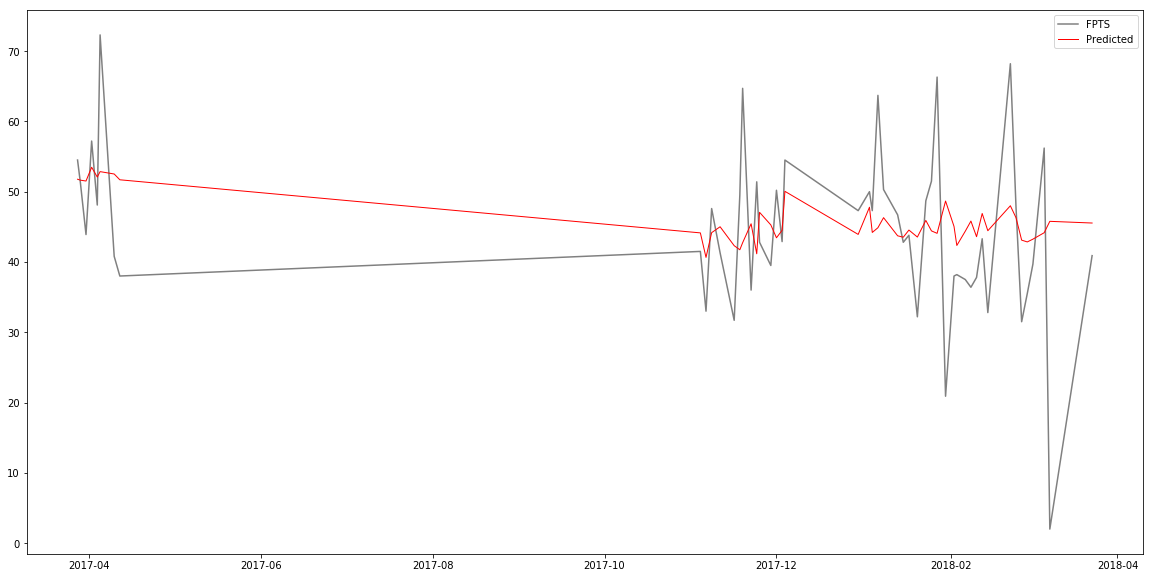

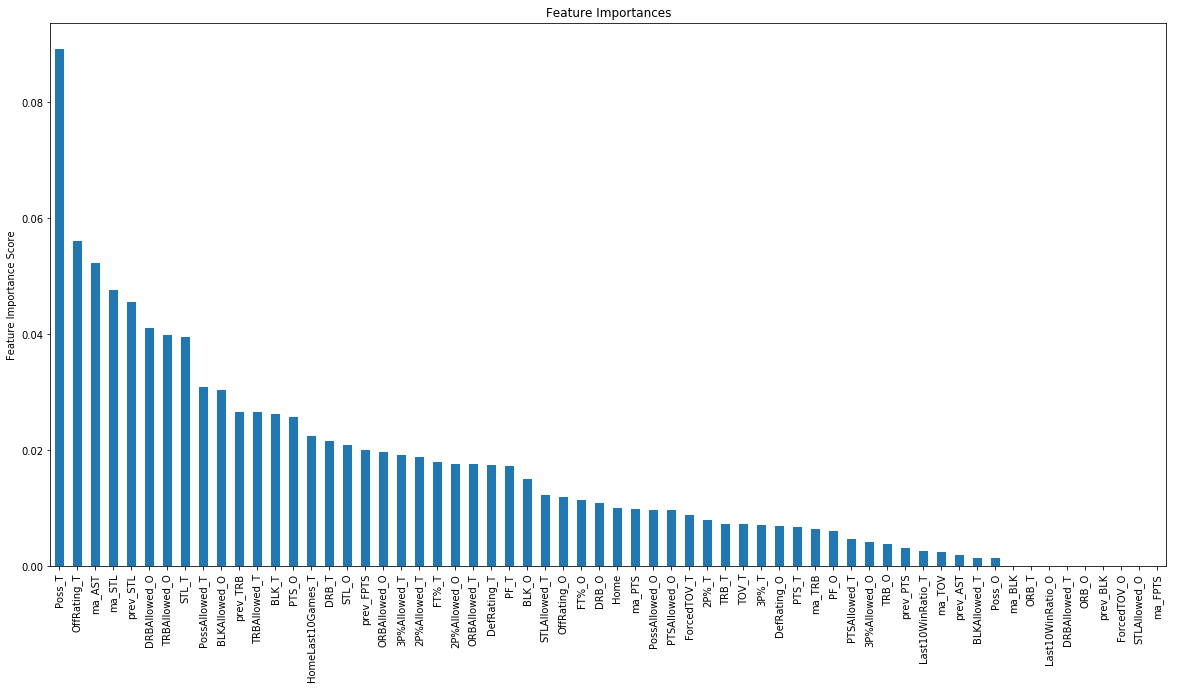

[ 0.          0.00982931  0.02156484  0.05231688  0.00727585  0.00638752
  0.04766466  0.0026715   0.00670977  0.05599957  0.00967986  0.03084835
  0.02001637  0.00800218  0.04103502  0.02617205  0.00322254  0.03994905
  0.01088291  0.01765834  0.00251054  0.02573462  0.00203395  0.01806207
  0.00139832  0.00704396  0.00701258  0.00976234  0.          0.00384421
  0.02666667  0.04549118  0.00415876  0.          0.01229577  0.02244218
  0.01148468  0.08925946  0.01001409  0.02094226  0.00721859  0.01195961
  0.03039707  0.          0.00612345  0.          0.03949801  0.
  0.01966572  0.          0.          0.01506496  0.          0.00476839
  0.02666667  0.01755739  0.00888572  0.01725868  0.00144015  0.01878024
  0.01922919  0.01744198]


In [181]:
#Call
predictors = [x for x in features if x != 'FPTS']
PredictPlayerStats(predictors,"Stephen Curry","FPTS")